<a href="https://colab.research.google.com/github/Astra-Stark/Astra-Stark/blob/main/Ayna_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install --quiet diffusers transformers accelerate safetensors wandb

import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import json
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import wandb


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.9 MB/s eta 0:00:00


In [ ]:
class PolygonColorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.inputs_dir = os.path.join(root_dir, "inputs")
        self.outputs_dir = os.path.join(root_dir, "outputs")
        self.mapping_file = os.path.join(root_dir, "data.json")
        self.transform = transform

        with open(self.mapping_file, 'r') as f:
            self.mappings = json.load(f)

        self.color_list = sorted(list({m["color"] for m in self.mappings}))
        self.color2idx = {c: i for i, c in enumerate(self.color_list)}

    def __len__(self):
        return len(self.mappings)

    def __getitem__(self, idx):
        item = self.mappings[idx]
        input_image = Image.open(os.path.join(self.inputs_dir, item["input"])).convert("RGB")
        output_image = Image.open(os.path.join(self.outputs_dir, item["output"])).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            output_image = self.transform(output_image)

        color_idx = self.color2idx[item["color"]]
        color_embedding = torch.nn.functional.one_hot(torch.tensor(color_idx), num_classes=len(self.color2idx)).float()

        return input_image, color_embedding, output_image


In [ ]:
transform = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])

train_dataset = PolygonColorDataset("/content/dataset/training", transform)
val_dataset = PolygonColorDataset("/content/dataset/validation", transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [1]:
# !pip install diffusers==0.27.2 timm



  Using cached diffusers-0.27.2-py3-none-any.whl.metadata (18 kB)
Using cached diffusers-0.27.2-py3-none-any.whl (2.0 MB)
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.34.0
    Uninstalling diffusers-0.34.0:
      Successfully uninstalled diffusers-0.34.0


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os, json
import numpy as np
import matplotlib.pyplot as plt
from diffusers import UNet2DConditionModel


In [4]:
class PolygonColorDataset(Dataset):
    def __init__(self, json_path, input_dir, output_dir, color_list, train=True):
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.colors = color_list
        # Augment more for train, less for val
        self.transform = transforms.Compose([
            transforms.Resize((128,128)),
            transforms.RandomHorizontalFlip() if train else transforms.Lambda(lambda x: x),
            transforms.RandomVerticalFlip() if train else transforms.Lambda(lambda x: x),
            transforms.ColorJitter(brightness=0.2, contrast=0.2) if train else transforms.Lambda(lambda x: x),
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        entry = self.data[idx]
        inp = Image.open(os.path.join(self.input_dir, entry['input_polygon'])).convert('RGB')
        outp = Image.open(os.path.join(self.output_dir, entry['output_image'])).convert('RGB')
        return self.transform(inp), torch.tensor(self.colors.index(entry['colour']), dtype=torch.long), self.transform(outp)


In [5]:
color_list = ["red", "green", "blue", "yellow", "cyan", "magenta", "orange", "purple"]

train_set = PolygonColorDataset(
    'dataset/dataset/training/data.json',
    'dataset/dataset/training/inputs',
    'dataset/dataset/training/outputs',
    color_list, train=True
)
val_set = PolygonColorDataset(
    'dataset/dataset/validation/data.json',
    'dataset/dataset/validation/inputs',
    'dataset/dataset/validation/outputs',
    color_list, train=False
)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16)


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet2DConditionModel(
    sample_size=(128, 128),
    in_channels=3,
    out_channels=3,
    block_out_channels=(64, 128, 256, 512),
    layers_per_block=2,
    class_embed_type="projection",
    num_class_embeds=len(color_list),
).to(device)


ValueError: `class_embed_type`: 'projection' requires `projection_class_embeddings_input_dim` be set

In [6]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),  # Scales to [0,1]
])

color_list = ["red", "green", "blue", "yellow", "cyan", "magenta", "orange", "purple"]  # adjust as needed


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Padding if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, n_colors, base_c=64, out_channels=3, bilinear=True):
        super().__init__()
        self.n_colors = n_colors
        self.color_embed = nn.Linear(n_colors, 32) # Can tune embedding size
        self.input_conv = DoubleConv(in_channels + 32, base_c) # Concatenate input and color embedding
        self.down1 = Down(base_c, base_c * 2)
        self.down2 = Down(base_c * 2, base_c * 4)
        self.down3 = Down(base_c * 4, base_c * 8)
        self.down4 = Down(base_c * 8, base_c * 8)
        self.up1 = Up(base_c * 16, base_c * 4, bilinear)
        self.up2 = Up(base_c * 8, base_c * 2, bilinear)
        self.up3 = Up(base_c * 4, base_c, bilinear)
        self.up4 = Up(base_c * 2, base_c, bilinear)
        self.outc = nn.Conv2d(base_c, out_channels, 1)

    def forward(self, x, color_onehot):
        # color_onehot: [batch_size, n_colors]
        batch_size, _, H, W = x.shape
        color_emb = self.color_embed(color_onehot)  # (batch_size, 32)
        # Expand and reshape for concat
        color_condition = color_emb.unsqueeze(2).unsqueeze(3).expand(-1, -1, H, W)  # [B, 32, H, W]
        x = torch.cat([x, color_condition], dim=1)  # [B, in_channels+32, H, W]
        x1 = self.input_conv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataset.zip to dataset.zip


In [2]:
import zipfile
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")


In [9]:
train_set = PolygonColorDataset(
    json_path='dataset/dataset/training/data.json',
    input_dir='dataset/dataset/training/inputs',
    output_dir='dataset/dataset/training/outputs',
    color_list=color_list,
    transform=transform
)

val_set = PolygonColorDataset(
    json_path='dataset/dataset/validation/data.json',
    input_dir='dataset/dataset/validation/inputs',
    output_dir='dataset/dataset/validation/outputs',
    color_list=color_list,
    transform=transform
)

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False)


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ConditionalUNet(in_channels=3, n_colors=len(color_list)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [11]:
wandb.init(project="polygon-color-unet")
wandb.watch(model, log='all')


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: astha27sharma (astha27sharma-oyo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [12]:
def train_one_epoch(loader, model, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for x, color, y in loader:
        x, color, y = x.to(device), color.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x, color)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def validate(loader, model, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x, color, y in loader:
            x, color, y = x.to(device), color.to(device), y.to(device)
            out = model(x, color)
            loss = criterion(out, y)
            total_loss += loss.item()
    return total_loss / len(loader)


In [13]:
num_epochs = 50
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(train_loader, model, optimizer, criterion, device)
    val_loss = validate(val_loader, model, criterion, device)

    wandb.log({"train_loss": train_loss, "val_loss": val_loss, "epoch": epoch})

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_conditional_unet.pth")


Epoch 1/50 | Train Loss: 0.9704 | Val Loss: 0.9299
Epoch 2/50 | Train Loss: 0.6186 | Val Loss: 0.9206
Epoch 3/50 | Train Loss: 0.3957 | Val Loss: 84.6644
Epoch 4/50 | Train Loss: 0.2447 | Val Loss: 34.7268
Epoch 5/50 | Train Loss: 0.2005 | Val Loss: 18.8654
Epoch 6/50 | Train Loss: 0.1453 | Val Loss: 180.3787
Epoch 7/50 | Train Loss: 0.1170 | Val Loss: 13.1505
Epoch 8/50 | Train Loss: 0.0935 | Val Loss: 2.6845
Epoch 9/50 | Train Loss: 0.0837 | Val Loss: 0.4852
Epoch 10/50 | Train Loss: 0.0864 | Val Loss: 0.4522
Epoch 11/50 | Train Loss: 0.0813 | Val Loss: 0.9377
Epoch 12/50 | Train Loss: 0.0790 | Val Loss: 1.8995
Epoch 13/50 | Train Loss: 0.0789 | Val Loss: 0.4575
Epoch 14/50 | Train Loss: 0.0732 | Val Loss: 0.8566
Epoch 15/50 | Train Loss: 0.0680 | Val Loss: 0.4937
Epoch 16/50 | Train Loss: 0.0658 | Val Loss: 0.1428
Epoch 17/50 | Train Loss: 0.0525 | Val Loss: 0.0895
Epoch 18/50 | Train Loss: 0.0531 | Val Loss: 0.2717
Epoch 19/50 | Train Loss: 0.0542 | Val Loss: 0.4163
Epoch 20/50 | T

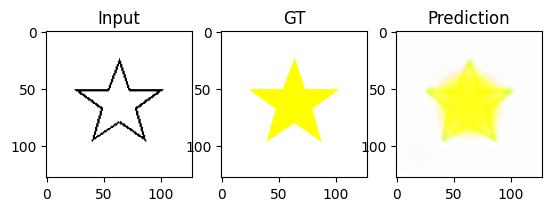

In [15]:
model.load_state_dict(torch.load("best_conditional_unet.pth", map_location=device))
model.eval()

# Get a sample
x, color, y = val_set[0]
with torch.no_grad():
    x_in = x.unsqueeze(0).to(device)
    color_in = color.unsqueeze(0).to(device)
    pred = model(x_in, color_in)
    pred_img = pred.squeeze().cpu().clamp(0,1).permute(1,2,0).numpy()
    import matplotlib.pyplot as plt
    plt.subplot(1,3,1); plt.imshow(x.permute(1,2,0)); plt.title("Input")
    plt.subplot(1,3,2); plt.title("GT"); plt.imshow(y.permute(1,2,0))
    plt.subplot(1,3,3); plt.title("Prediction"); plt.imshow(pred_img)
    plt.show()
